# DDPM and Mixed Precision

> In this module, we implement the DDPM training and inference algorithm using the Huggingface U-net implementation. We also adopt some hardware-level performance improvement to train much more quickly.

Adapted from:

- [https://youtu.be/ItyO8s48zdc?si=kJBUmXzJ2ihUj63b&t=737](https://youtu.be/ItyO8s48zdc?si=kJBUmXzJ2ihUj63b&t=737)

In [1]:
#| default_exp ddpm

In [2]:
# |export
import random
import re
from contextlib import contextmanager
from functools import partial
from math import sqrt
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from accelerate import Accelerator
from diffusers import LMSDiscreteScheduler
from einops import rearrange
from IPython.display import Markdown, display
from torch import distributions, nn
from torch.nn import init
from torch.optim import lr_scheduler
from torchmetrics.classification import MulticlassAccuracy
from torchvision import transforms
from tqdm import tqdm

from slowai.activations import StoreModuleStatsCB, set_seed
from slowai.initializations import init_leaky_weights, set_seed
from slowai.learner import (
    Callback,
    DataLoaders,
    DeviceCB,
    Learner,
    MetricsCB,
    ProgressCB,
    TrainCB,
    TrainLearner,
    after,
    batchify,
    def_device,
    fashion_mnist,
    only,
    tensorize_images,
)
from slowai.resnets import Conv, ResidualConvBlock
from slowai.sgd import BatchSchedulerCB
from slowai.utils import show_image, show_images

In [3]:
plt.style.use("ggplot")

### Prelude

The huggingface U-net requires an image that has a height/width of a power of 2.

I'm also removing global normalization, as that seemed to degrade performance compared to scaling between 0 and 1.

In [4]:
def get_dls(bs=128):
    pipe = [
        T.Resize((32, 32)),  # 👈 here...
        T.PILToTensor(),
        T.ConvertImageDtype(torch.float),
    ]
    return tensorize_images(
        DataLoaders.from_hf("fashion_mnist", bs=bs),
        pipe=pipe,
        normalize=False,  # 👈 ...and here
    ).listify()


dls = get_dls()
xb, _ = dls.peek()
xb.shape

torch.Size([128, 1, 32, 32])

<Axes: >

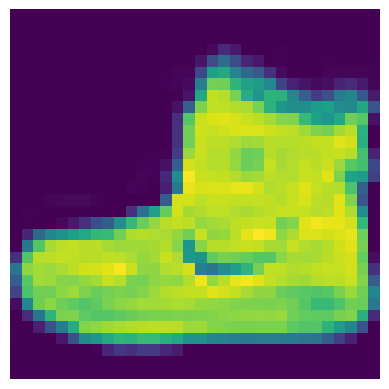

In [5]:
show_image(xb[0, ...])

(array([70274.,  4709.,  4792.,  5277.,  6619.,  6254.,  7328.,  9274.,
        11526.,  5019.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

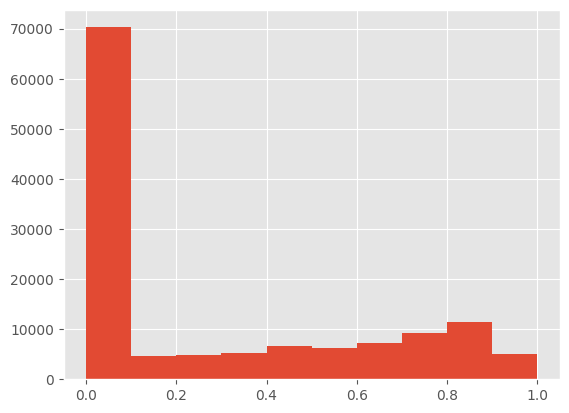

In [6]:
plt.hist(xb.view(-1))

The diffusion model paper is available [here](https://arxiv.org/pdf/2006.11239.pdf) and proposes an important simplification that improved the performance of this kind of modeling.

:::{.callout-tip}
## Is diffusion ideal for generating images?
Jeremy mentions that, even shortly after the Stable Diffusion release, better models were in progress that had comparable performance that do not use diffusion. "Iterative refinement" may be a better term that encompasses other models, such as GANs.

See this [clarifying post](https://forums.fast.ai/t/lesson-19-official-topic/103201/32) for details.
:::

## Review, lesson 9b

"Generative modeling" produces some complicated probability distribution, such that sampling produces a complicated example. GAN's and VAE's can produce such a distribution, and **iterative refinement models** can do so as well.

![https://miro.medium.com/v2/resize:fit:1200/1*MLRitrnUdOy6rPtZfNwO4w.png](https://miro.medium.com/v2/resize:fit:1200/1*MLRitrnUdOy6rPtZfNwO4w.png) 

The forward process is defined recurively like so: $$
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} (x_{t-1}), \beta_t I)
$$

During the forward process of diffusion, the mean decreases and the variance increases. In other words, the original image is lost and is replaced by pure noise.

It's easy to compute the forward process for a given $X$ and $t$. There is, in fact, a closed-form solution for a given $\{\beta_0,...,\beta_T\}$

$$
\begin{align*}
\epsilon &\sim \mathcal{N}(0, I) \\
\alpha_t &= 1-\beta_t \\
\bar{\alpha_t} &= \prod_{i=0}^t \alpha_i \\
     x_t &= \sqrt{\bar{\alpha_t}} x_0 + \sqrt{1-\bar{\alpha_t}} \epsilon
\end{align*}
$$

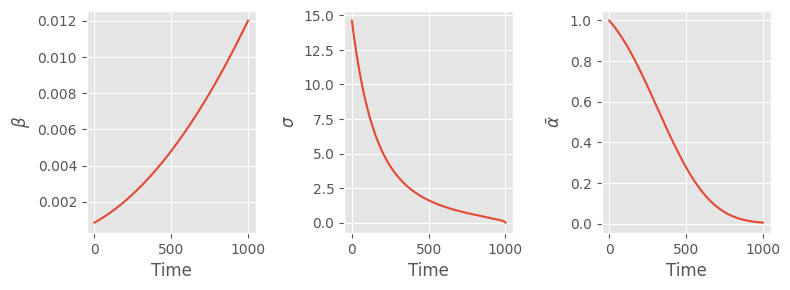

In [7]:
s = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(8, 3))
a0.plot(s.betas)
a0.set(xlabel="Time", ylabel=r"$\beta$")
a1.plot(s.sigmas)
a1.set(xlabel="Time", ylabel=r"$\sigma$")
a2.plot(s.alphas_cumprod)
a2.set(xlabel="Time", ylabel=r"$\bar{\alpha}$")
fig.tight_layout()

To review:

- $\beta$ and $\sigma$ are the mean and standard deviation (respectively) of the noise added to the image at each step
- $\bar{\alpha}$ is the cumulative amount of noise added at a particular time

To train this model, we:

1. Randomly select a timepoint, $t$ and add the apropriate amount of noise to the image
2. Predict the added noise and back-prop with MSE loss

Specifically, we need the equation from the paper **Algorithm 1**.

$$
\begin{align*}
       t &\sim Uniform(\{1,...,T\}) \\
\epsilon &\sim \mathcal{N}(0, I) \\
    loss &= MSE \left( \epsilon, \epsilon_\theta ( \sqrt{\bar{\alpha_t}} x_0 + \sqrt{1-\bar{\alpha_t}} \epsilon, t ) \right) \\
\end{align*}
$$

Here, $\epsilon_\theta$ is a neural network that **predicts the mean** and uses a fixed variance.

In [8]:
class DDPM(Callback, order=after(DeviceCB)):
    def __init__(self, n_steps=1000, βmin=0.0001, βmax=0.02):
        self.n_steps = n_steps
        self.βmin = βmin
        self.βmax = βmax
        self.β = torch.linspace(βmin, βmax, n_steps)
        self.ɑ = 1 - self.β
        self.ᾱ = torch.cumprod(self.ɑ, dim=0)
        self.σ = self.β.sqrt()

    def before_batch(self, learn):
        # Starting with the original image
        x_0, _ = learn.batch
        device = x_0.device
        self.ᾱ = self.ᾱ.to(device)

        # Sample 2D noise for each example in the batch
        ε = torch.randn(x_0.shape, device=device)
        n, *_ = x_0.shape

        # Add noise according to the equation in Algorithm 1, such
        # that the variance of the distribution does not change
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        x_t = ᾱ_t.sqrt() * x_0 + (1 - ᾱ_t).sqrt() * ε

        learn.batch = ((x_t, t), ε)

    @only
    def predict(self, learn):
        (x_t, t), _ = learn.batch
        learn.preds = learn.model(x_t, t).sample

By iteratively predicting the noise and removing it, ultimately we end up with a high probability data point.

This is defined in **Algorithm 2** in the DDPM paper

$$
\begin{align*}
z &\sim \mathcal{N}(0, I) \text{ if } t > 1 \text{ else } z=0 \\
\hat{x}_{t-1} &= \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z
\end{align*}
$$

Let's break this down into manageable chunks

| Equation | Description |
|---|:---|
| $$z \sim \mathcal{N}(0, I) \text{ if } t > 1 \text{ else } z=0$$ | Samples a noise vector from a standard normal distribution if t > 1, otherwise sets z to 0 |
| $$\epsilon_\theta(x_t, t)$$ | Represents the neural network |
| $$\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}$$ | The predicted noise scaling factor required such that the mean of the predicted noise matches that of $x_t$ |
| $$x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) $$ | $\hat{x}_0$ |
|  $$ \frac{1}{\sqrt{\alpha_t}} $$| The overall scaling factor required such that adding $ \sigma_t z $ yields a mean and variance apropriate to the schedule |
| $$\sigma_t z$$| Noise to add to the predicted $x_0$ to get $x_{t-1}$ |


See [Tanishq's post](https://forums.fast.ai/t/lesson-19-official-topic/103201/16) for details on the derivation of the coefficients.

In [9]:
@torch.no_grad()
def sample(self, model, sz=(16, 1, 32, 32), device=def_device):
    ᾱ, ɑ, σ = self.ᾱ.to(device), self.ɑ.to(device), self.σ.to(device)
    x_t = torch.randn(sz, device=device)
    bs, *_ = sz
    preds = []
    iter_ = list(reversed(range(1, self.n_steps)))
    for t in tqdm(iter_, unit="time step"):
        # Predict the noise for each example in the image
        t_batch = torch.full((bs,), fill_value=t, device=device, dtype=torch.long)
        noise_pred = model(x_t, t_batch).sample

        # Predict the image without noise
        x_0_pred = x_t - (1 - ɑ[t]) / torch.sqrt(1 - ᾱ[t]) * noise_pred

        # Add noise to the predicted noiseless image such that it ulimately
        # has slightly less noise than before
        x_t_minus_1 = x_0_pred / ɑ[t].sqrt() + (σ[t] * torch.randn(sz, device=device))

        # Repeat
        x_t = x_t_minus_1

    # At the last step, simply rescale and do not add noise
    x_0 = x_0_pred / ɑ[0].sqrt()
    return x_0


DDPM.sample = sample

# Architecture

Our model is a U-Net, with some modern tricks like attention.

![https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [10]:
from diffusers import UNet2DModel

In [11]:
UNet2DModel().down_blocks[0]

DownBlock2D(
  (resnets): ModuleList(
    (0-1): 2 x ResnetBlock2D(
      (norm1): GroupNorm(32, 224, eps=1e-05, affine=True)
      (conv1): LoRACompatibleConv(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_emb_proj): LoRACompatibleLinear(in_features=896, out_features=224, bias=True)
      (norm2): GroupNorm(32, 224, eps=1e-05, affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (conv2): LoRACompatibleConv(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlinearity): SiLU()
    )
  )
  (downsamplers): ModuleList(
    (0): Downsample2D(
      (conv): LoRACompatibleConv(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
)

Let's give this a test run.

In [12]:
def train(
    model,
    lr=4e-3,
    n_epochs=2,
    bs=128,
    opt_func=torch.optim.Adam,
    extra_cbs=[],
    ddpm=DDPM(),
):
    dls = get_dls(bs)
    T_max = len(dls["train"]) * n_epochs
    cbs = [
        ddpm,
        TrainCB(),
        MetricsCB(),
        DeviceCB(),
        ProgressCB(plot=True),
        BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max),
        *extra_cbs,
    ]
    Learner(
        model,
        dls,
        F.mse_loss,
        lr=lr,
        cbs=cbs,
        opt_func=opt_func,
    ).fit(n_epochs)
    return ddpm

In [13]:
def fashion_unet():
    return UNet2DModel(
        sample_size=(32, 32),
        in_channels=1,
        out_channels=1,
        block_out_channels=(16, 32, 64, 128),
        # Group norm splits channels into groups, such that the number of
        # convolutional channels should be divisable by `norm_num_groups`
        norm_num_groups=8,
    )

loss,epoch,train
0.070,0,train
0.024,0,eval
0.020,1,train
0.019,1,eval


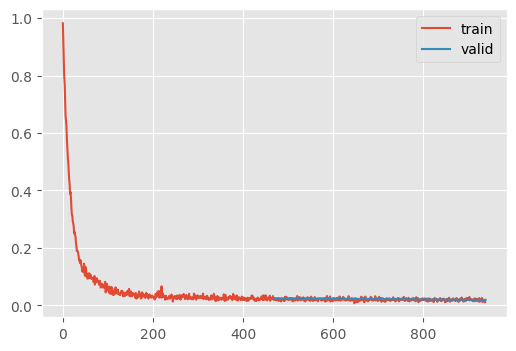

CPU times: user 1min 5s, sys: 4.65 s, total: 1min 10s
Wall time: 1min 12s


In [14]:
%%time
unet = fashion_unet()
ddpm = train(unet)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:15<00:00, 66.59time step/s]


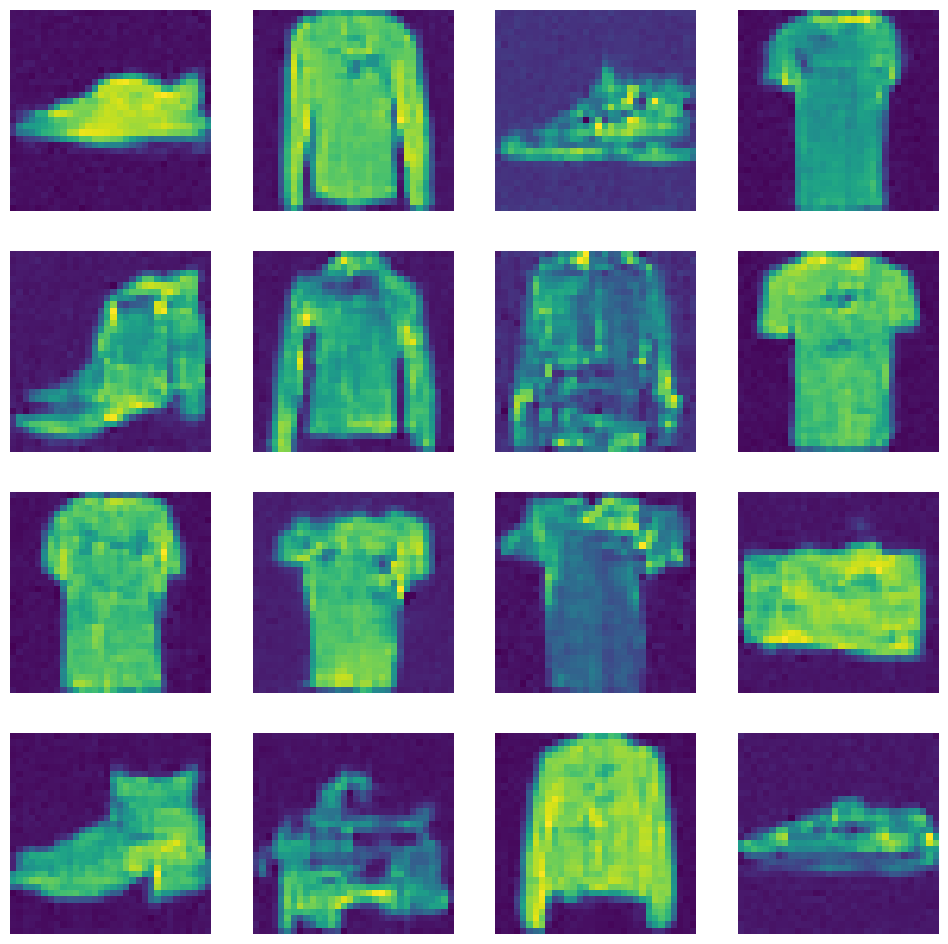

In [15]:
imgs = ddpm.sample(unet)
show_images(imgs)

# Initialization

`diffusers` does not perform initialization. Let's fix this by:

- Making the non-residual weights into a zero-convolution, such that the training dynamics resemble that of a smaller, more stable network
- Using orthoganol initialization for the downsampler blocks

:::{.callout-tip}
## Orthoganol initialization
Jeremy mentions here that he spoke to Katherine Crowson who wrote [K-diffusion](https://github.com/crowsonkb/k-diffusion) and recommended using orthoganol initialization. To understand the motivation behind orthoganol weights, Jeremy recommends taking Rachel's Thomas'
[computational linear algrebra course](https://www.fast.ai/posts/2017-07-17-num-lin-alg.html).

I'll take a shot at summarizing this. Suppose $W$ is a matrix where each row is approximately orthonormal to each other row and has a unit-magnitude. Under such a linear transormation, the scale of the input vector is preserved. (An identity matrix has the same property.)

Moreover, orthonormal feature extractors __may__ learn different representations of the input features. This is basically a change of basis function, so neurons will have a mixure of different features in a different from the underlying layer, but the magnitude does not change.
:::

In [16]:
init.orthogonal_?

Signature: init.orthogonal_(tensor, gain=1)
Docstring:
Fills the input `Tensor` with a (semi) orthogonal matrix, as
described in `Exact solutions to the nonlinear dynamics of learning in deep
linear neural networks` - Saxe, A. et al. (2013). The input tensor must have
at least 2 dimensions, and for tensors with more than 2 dimensions the
trailing dimensions are flattened.

Args:
    tensor: an n-dimensional `torch.Tensor`, where :math:`n \geq 2`
    gain: optional scaling factor

Examples:
    >>> # xdoctest: +REQUIRES(env:TORCH_DOCTEST_LAPACK)
    >>> w = torch.empty(3, 5)
    >>> nn.init.orthogonal_(w)
File:      ~/micromamba/envs/slowai/lib/python3.11/site-packages/torch/nn/init.py
Type:      function

In [17]:
@torch.no_grad()
def init_(self):
    for down_block in self.down_blocks:
        for resnet in down_block.resnets:
            resnet.conv2.weight.data.zero_()

            # Not sure why this is indented
            if down_block.downsamplers is not None:
                for downsampler in down_block.downsamplers:
                    init.orthogonal_(downsampler.conv.weight)

    for up_block in self.up_blocks:
        for resnet in up_block.resnets:
            resnet.conv2.weight.zero_()

    self.conv_out.weight.data.zero_()


UNet2DModel.init_ = init_

loss,epoch,train
0.860,0,train
1.000,0,eval


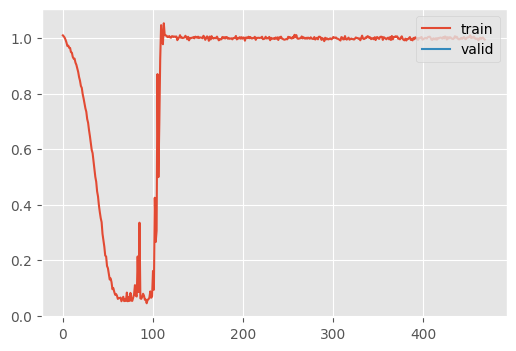

In [18]:
unet = fashion_unet()
unet.init_()
train(unet, n_epochs=1);

This (sometimes) explodes at the highest learning rate. Recall, in RMSProp, the gradients are divided by the expontentially weighted square of the gradients plus $\epsilon$. If the gradients are small, and $\epsilon$ is also small, then the learning rate becomes extremely large.

Increasing $\epsilon$ can mitigate this.

loss,epoch,train
0.125,0,train
0.021,0,eval
0.019,1,train
0.018,1,eval


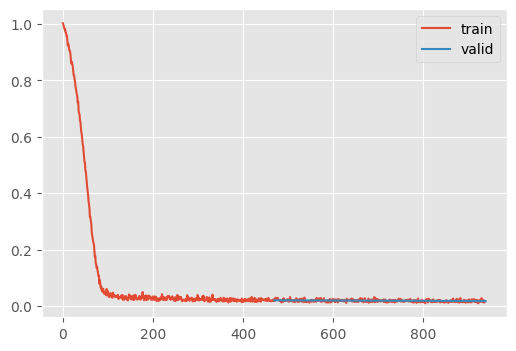

CPU times: user 1min 5s, sys: 5.52 s, total: 1min 10s
Wall time: 1min 11s


In [19]:
%%time
unet = fashion_unet()
unet.init_()
ddpm = train(unet, opt_func=partial(torch.optim.Adam, eps=1e-5))

This might slightly improve results. I was getting about **twice the loss** as Jeremy's version, but I removed the global normalization and now I get competitive performance **without** orthoganol normalization.

## Speeding up training

GPUs are extremely fast at 16-bit precision. Unfortunately, not everything can be done at such low precision. Most training is performed using "mixed precision."

We can adapt the example in the Torch docs to that of a Callback

```python
use_amp = True

net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

start_timer()
for epoch in range(epochs):
    for input, target in zip(data, targets):
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad() # set_to_none=True here can modestly improve performance
```

In [26]:
# |export
class MixedPrecision(TrainCB, order=after(DeviceCB)):
    def before_fit(self, learn):
        self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn):
        self.autocast.__exit__(None, None, None)

    @only
    def backward(self, learn):
        self.scaler.scale(learn.loss).backward()

    @only
    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

Since `fp16` takes only a fraction of the original representation memory space and processing time, we can dramatically increase the batch size. However, since we have fewer opportunities to update per epoch, we need to compensate with a higher learning rate and more epochs.

loss,epoch,train
0.257,0,train
0.030,0,eval
0.026,1,train
0.025,1,eval
0.022,2,train
0.021,2,eval
0.019,3,train
0.019,3,eval
0.018,4,train
0.017,4,eval


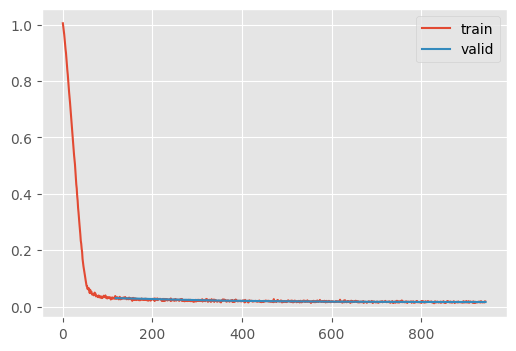

CPU times: user 1min 47s, sys: 24.2 s, total: 2min 11s
Wall time: 2min 16s


In [27]:
%%time
unet = fashion_unet()
unet.init_()
train(
    unet,
    lr=1e-2,
    n_epochs=8,
    bs=512,
    opt_func=partial(torch.optim.Adam, eps=1e-5),
    extra_cbs=[MixedPrecision()],
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:15<00:00, 64.49time step/s]


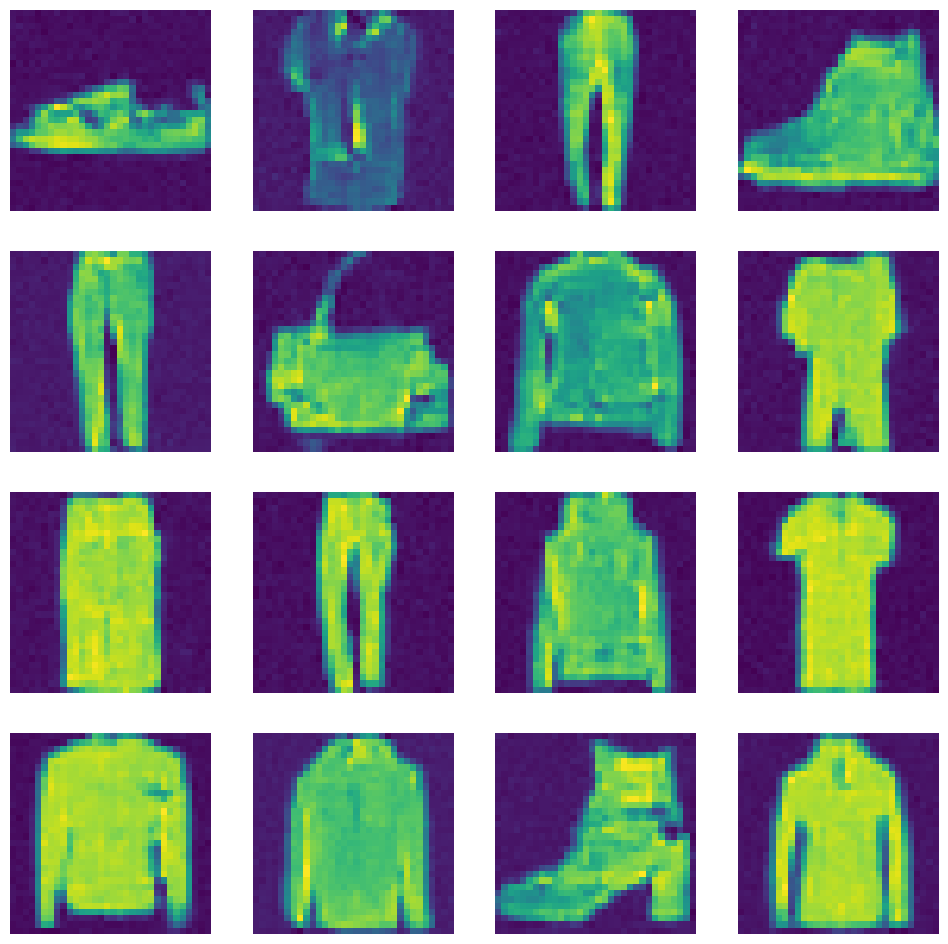

In [28]:
imgs = ddpm.sample(unet)
show_images(imgs)

This makes training for longer more feasible, ultimately resulting in a lower loss.

I tried a lot of configurations for this loop. It would usually diverge, until I increased the number of epochs to 8. This probably spread out the learning rate scheduling.

## Accelerate

[Accelerate](https://huggingface.co/docs/accelerate/index) was developed by Sylvain Gugger at Huggingface to convert existing PyTorch code (and PyTorch-framework, like ours) to use optimizations such as:

- [**ZeRO-Offload**:](https://arxiv.org/abs/1910.02054) enables multi-billion parameter model training by  offloading tensor storage to the CPU and reloading strategically onto the GPU before computation (Author presentation [here](https://www.youtube.com/watch?v=Hdzh4fJv4yY))
- [**Fully-sharded data parallelism**:](https://engineering.fb.com/2021/07/15/open-source/fsdp/) divide the compute graph into shards, such that each shard computes an intermediate activation and dispatches it  to the apropriate GPU
- **Mixed Precision Training**

In [29]:
# |export
class AccelerateCB(TrainCB, order=after(DeviceCB)):
    def __init__(self, mixed_precision="fp16"):
        self.acc = Accelerator(mixed_precision=mixed_precision)

    def before_fit(self, learn):
        learn.model, learn.opt, train, test = self.acc.prepare(
            learn.model,
            learn.opt,
            learn.dls["train"],
            learn.dls["test"],
        )
        learn.dls = {"train": train, "test": test}

    @only
    def backward(self, learn):
        self.acc.backward(learn.loss)

loss,epoch,train
0.209,0,train
0.041,0,eval
0.028,1,train
0.033,1,eval
0.024,2,train
0.023,2,eval
0.020,3,train
0.021,3,eval
0.019,4,train
0.019,4,eval


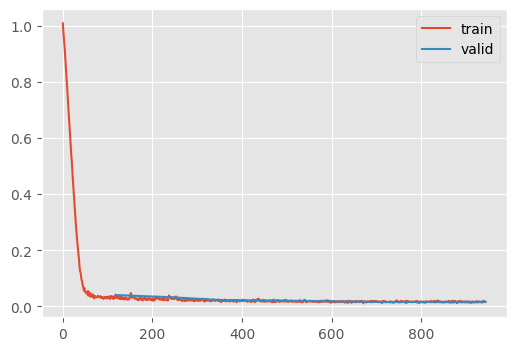

CPU times: user 2min, sys: 23.7 s, total: 2min 24s
Wall time: 2min 30s


In [30]:
%%time
unet = fashion_unet()
unet.init_()
train(
    unet,
    lr=1e-2,
    n_epochs=8,
    bs=512,
    opt_func=partial(torch.optim.Adam, eps=1e-5),
    extra_cbs=[AccelerateCB()],
)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()